## CONFIG

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
from folium.plugins import HeatMap
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import geodesic
from tqdm import tqdm

In [2]:
DB_FILE_PATH = "house_prices.db"

## READING DATABASE

In [3]:
data = {}
conn = sqlite3.connect(DB_FILE_PATH)
data["all"] = pd.read_sql_query("SELECT * FROM mieszkanka",conn)
conn.close()

In [4]:
data["all"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99170 entries, 0 to 99169
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           99170 non-null  int64  
 1   developer    99170 non-null  object 
 2   investment   99170 non-null  object 
 3   number       99170 non-null  object 
 4   area         99170 non-null  float64
 5   price        99170 non-null  int64  
 6   country      99160 non-null  object 
 7   voivodeship  99160 non-null  object 
 8   county       27478 non-null  object 
 9   city         96290 non-null  object 
 10  district     58707 non-null  object 
 11  lat          99170 non-null  float64
 12  lng          99170 non-null  float64
 13  floor        95730 non-null  float64
 14  floors       99170 non-null  int64  
 15  balcony      35211 non-null  float64
 16  loggia       6663 non-null   float64
 17  terrace      9250 non-null   float64
 18  garden       10019 non-null  float64
dtypes: f

In [5]:
data["all"].describe()

id          area         price           lat           lng  \
count  99170.000000  99170.000000  9.917000e+04  99170.000000  99170.000000   
mean   49585.500000     58.439314  7.961183e+05     18.304330     51.523458   
std    28628.057435     31.481649  6.705208e+05      4.232786      2.891869   
min        1.000000      5.000000  2.100000e+05     -5.273033     36.323581   
25%    24793.250000     40.230000  5.000000e+05     17.021745     50.810471   
50%    49585.500000     51.390000  6.600000e+05     19.029263     52.080934   
75%    74377.750000     66.670000  8.800000e+05     20.640453     52.456515   
max    99170.000000   1239.300000  2.591640e+07     23.514184     54.830454   

              floor        floors       balcony       loggia      terrace  \
count  95730.000000  99170.000000  35211.000000  6663.000000  9250.000000   
mean       2.683004      1.082414      7.979922     6.844572    25.032791   
std        2.744205      0.322050      7.281906     5.928909    30.332002   
min       -1.000000      1.000000      0.440000     0.670000     1.000000   
25%        1.000000      1.000000      4.490000     3.620000     7.580000   
50%        2.000000      1.000000      5.830000     5.270000    15.000000   
75%        4.000000      1.000000      9.020000     8.000000    29.510000   
max       40.000000      5.000000    189.870000    86.480000   403.960000   

             garden  
count  10019.000000  
mean      79.108702  
std      101.381851  
min        0.970000  
25%       24.625000  
50%       46.120000  
75%       93.010000  
max     1313.910000

In [6]:
data["all"].value_counts("country")

country
PL    96036
ES     3124
Name: count, dtype: int64

## PREPARING DATASET

In [7]:
data["all"] = data["all"].query("country == 'PL'")
# dropping column with country, because we only want to analyse Polish market
data["all"] = data["all"].drop(columns=['country'])

In [8]:
data["all"].isnull().sum()

id                 0
developer          0
investment         0
number             0
area               0
price              0
voivodeship        0
county         68558
city            2803
district       37343
lat                0
lng                0
floor           3205
floors             0
balcony        60892
loggia         89392
terrace        89362
garden         86553
dtype: int64

In [9]:
# dropping column with county and district - later to be received from GUS API
data["all"] = data["all"].drop(columns=['county', 'district'])

In [10]:
data["all"] = data["all"][~data["all"]['city'].isna()]

In [11]:
data["all"].loc[:, 'balcony'] = data["all"]['balcony'].fillna(0)
data["all"].loc[:, 'loggia'] = data["all"]['loggia'].fillna(0)
data["all"].loc[:, 'terrace'] = data["all"]['terrace'].fillna(0)
data["all"].loc[:, 'garden'] = data["all"]['garden'].fillna(0)
data["all"].loc[:, 'floor'] = data["all"]['floor'].fillna(-1) # to distinguish it from floor 0



In [12]:
data["all"]['price_m2'] = data["all"]['price']/ data['all']['area']

In [13]:
data["all"]['is_commercial'] = data["all"]['number'].str.startswith('U')

In [14]:
data["all"].describe()

id          area         price           lat           lng  \
count  93233.000000  93233.000000  9.323300e+04  93233.000000  93233.000000   
mean   49577.007798     56.014762  7.429567e+05     18.985317     51.988230   
std    28563.517981     26.734128  4.256041e+05      1.970037      1.388266   
min        1.000000      5.000000  2.100000e+05     14.232837     49.281500   
25%    24734.000000     39.900000  5.000000e+05     17.064818     51.055766   
50%    49498.000000     50.140000  6.500000e+05     19.091438     52.117108   
75%    74375.000000     64.900000  8.500000e+05     20.673060     52.569699   
max    99170.000000   1239.300000  2.065860e+07     23.514184     54.830454   

              floor        floors       balcony        loggia       terrace  \
count  93233.000000  93233.000000  93233.000000  93233.000000  93233.000000   
mean       2.628533      1.069428      2.939781      0.483560      1.160354   
std        2.762055      0.299010      5.642625      2.326872      6.624174   
min       -1.000000      1.000000      0.000000      0.000000      0.000000   
25%        1.000000      1.000000      0.000000      0.000000      0.000000   
50%        2.000000      1.000000      0.000000      0.000000      0.000000   
75%        4.000000      1.000000      4.700000      0.000000      0.000000   
max       35.000000      5.000000    138.620000     86.480000    403.960000   

             garden       price_m2  
count  93233.000000   93233.000000  
mean       7.191349   13782.140294  
std       35.644420    5255.657334  
min        0.000000     855.321552  
25%        0.000000   10314.262691  
50%        0.000000   12748.295286  
75%        0.000000   15912.305516  
max     1313.910000  198000.000000

In [15]:
data["all"] = data["all"].rename(columns={"lng":"lat", "lat":"lng"})

## FIXING OUTLIERS

In [16]:
data["all"].sort_values('price_m2')

id                              developer  \
25176  25177                                    ARD   
47969  47970                      Novdom Sp. z o.o.   
81279  81280                   Eldor Bud Sp. z o.o.   
8344    8345                   Eldor Bud Sp. z o.o.   
36193  36194         Apartamenty Szczyrk Sp. z o.o.   
...      ...                                    ...   
70891  70892  Assethome – Przedstawiciel Dewelopera   
86144  86145  Assethome – Przedstawiciel Dewelopera   
23902  23903                      Novdom Sp. z o.o.   
68677  68678               Matexi Polska Sp. z o.o.   
29745  29746                 Platforma Mieszkaniowa   

                           investment   number     area     price  \
25176  Apartamenty na Chopina II etap    C.4.3  1239.30   1060000   
47969           Apartamenty Macadamia       18   227.94    640000   
81279    Osiedle Żeromskiego etap III        P   194.96    610000   
8344     Osiedle Żeromskiego etap III        P   194.96    620000   
36193             Apartamenty Szczyrk      A18    74.30    260000   
...                               ...      ...      ...       ...   
70891     The Sea Resort Międzyzdroje    B1-03    80.45   5730000   
86144     The Sea Resort Międzyzdroje    A1-05    60.34   4380000   
23902           Apartamenty Macadamia       32    35.57   2640000   
68677                      Żelazna 54  U.00.02   184.16  20658600   
29745                 Naramowicka 172    A0.01     5.00    990000   

               voivodeship          city        lng        lat  floor  floors  \
25176   kujawsko-pomorskie     Bydgoszcz  18.021742  53.124240    4.0       2   
47969  warmińsko-mazurskie       Olsztyn  20.480141  53.781898    5.0       1   
81279          mazowieckie      Tobolice  21.595880  53.046051   -1.0       2   
8344           mazowieckie      Tobolice  21.595880  53.046051   -1.0       2   
36193              śląskie       Szczyrk  19.029234  49.718571    2.0       1   
...                    ...           ...        ...        ...    ...     ...   
70891   zachodniopomorskie  Międzyzdroje  14.443170  53.930185    1.0       1   
86144   zachodniopomorskie  Międzyzdroje  14.443170  53.930185    1.0       1   
23902  warmińsko-mazurskie       Olsztyn  20.480141  53.781898    4.0       1   
68677          mazowieckie      Warszawa  20.991590  52.233865    0.0       1   
29745        wielkopolskie        Poznań  16.948366  52.451507    0.0       1   

       balcony  loggia  terrace  garden       price_m2  is_commercial  
25176    21.00     0.0     44.0     0.0     855.321552          False  
47969    31.45     3.7      0.0     0.0    2807.756427          False  
81279     0.00     0.0      0.0     0.0    3128.846943          False  
8344      0.00     0.0      0.0     0.0    3180.139516          False  
36193     0.00     0.0      0.0     0.0    3499.327052          False  
...        ...     ...      ...     ...            ...            ...  
70891     0.00     0.0      0.0     0.0   71224.362958          False  
86144     0.00     0.0      0.0     0.0   72588.664236          False  
23902     7.83     0.0      0.0     0.0   74219.848187          False  
68677     0.00     0.0      0.0     0.0  112177.454387           True  
29745     0.00     0.0      0.0     0.0  198000.000000          False  

[93233 rows x 18 columns]

In [17]:
# manual fix
#data["all"].at[25177, "area"] /= 10
data["all"].at[29745, "area"] = 72.27
data["all"].at[68677, "price"] = 4984000
data["all"].at[23902, "price"] = 650000


In [18]:
data["all"]["price_m2"] = data["all"]["price"] / data["all"]["area"]

## GRAPHICAL REPRESENTATION

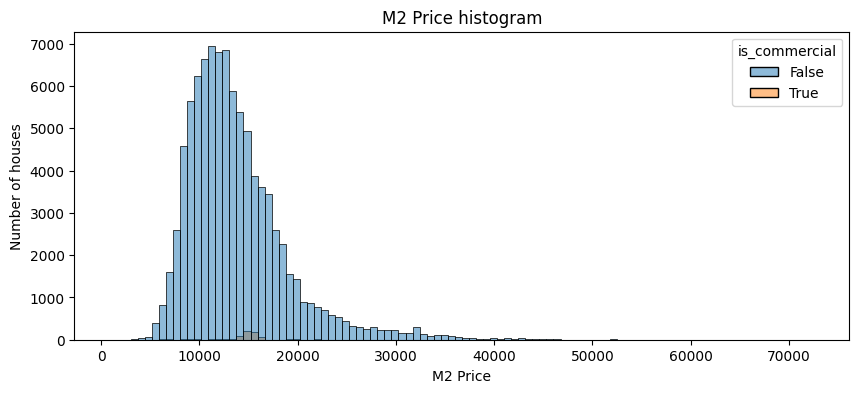

In [19]:
plt.figure(figsize=(10,4))
sns.histplot(data = data['all'],
             x='price_m2',
             bins = 100,
             hue = 'is_commercial')
plt.title("M2 Price histogram")
plt.xlabel("M2 Price")
plt.ylabel("Number of houses")
plt.show()

In [20]:
## counting outliers
display(data["all"][data["all"]["price_m2"] > 30_000].shape[0])
display(data["all"].shape[0])

1689

93233

In [21]:
mask = data["all"][data["all"]["price_m2"] > 30_000]
data["all"] = data["all"].drop(mask.index).reset_index(drop=True)
mask = data["all"][data["all"]["price_m2"] < 5_000]
data["all"] = data["all"].drop(mask.index).reset_index(drop=True)

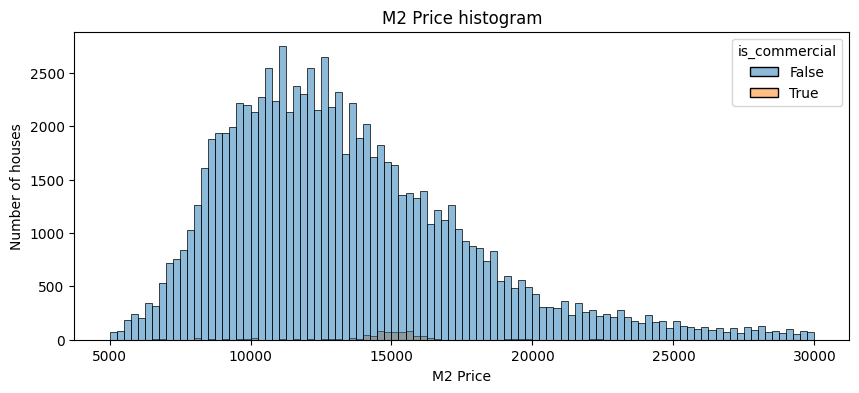

In [22]:
plt.figure(figsize=(10,4))
sns.histplot(data = data['all'],
             x='price_m2',
             bins = 100,
             hue = 'is_commercial')
plt.title("M2 Price histogram")
plt.xlabel("M2 Price")
plt.ylabel("Number of houses")
plt.show()

In [23]:
data['all'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91471 entries, 0 to 91470
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             91471 non-null  int64  
 1   developer      91471 non-null  object 
 2   investment     91471 non-null  object 
 3   number         91471 non-null  object 
 4   area           91471 non-null  float64
 5   price          91471 non-null  int64  
 6   voivodeship    91471 non-null  object 
 7   city           91471 non-null  object 
 8   lng            91471 non-null  float64
 9   lat            91471 non-null  float64
 10  floor          91471 non-null  float64
 11  floors         91471 non-null  int64  
 12  balcony        91471 non-null  float64
 13  loggia         91471 non-null  float64
 14  terrace        91471 non-null  float64
 15  garden         91471 non-null  float64
 16  price_m2       91471 non-null  float64
 17  is_commercial  91471 non-null  bool   
dtypes: boo

In [24]:
data["all"].loc[:,"is_detached"] = data['all']["floor"] == -1

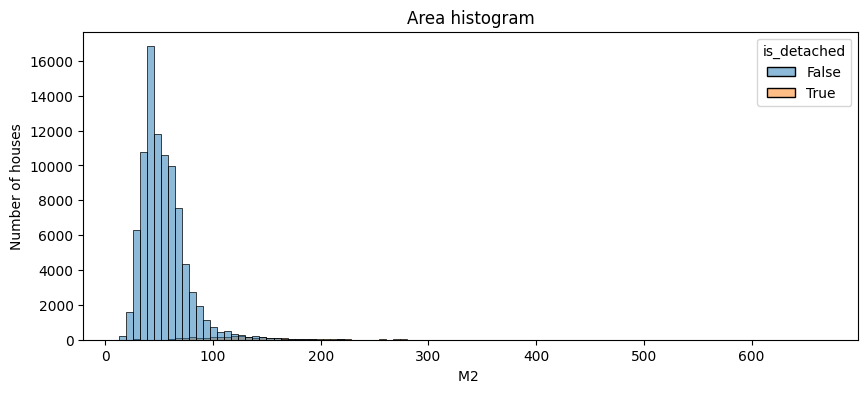

In [25]:
plt.figure(figsize=(10,4))
sns.histplot(data = data['all'],
             x='area',
             bins = 100,
             hue = 'is_detached')
plt.title("Area histogram")
plt.xlabel("M2 ")
plt.ylabel("Number of houses")
plt.show()

In [26]:
data["all"].sort_values("area").tail(10)

id                developer            investment number    area  \
23254  25171                  PROFBUD             Gaia Park     17  339.60   
23255  25172                  PROFBUD             Gaia Park     18  339.60   
18371  19964                  PROFBUD             Gaia Park     26  339.60   
57042  61556     modernBau Sp. z o.o.           Willa Fiore      1  346.43   
13846  15105            ABM Deweloper          Nowe Sady 85     U1  354.57   
37162  40437             Revisit Home      Słoneczne Tarasy     U2  358.40   
27929  30439  Działyńskich Sp. z o.o.        Działyńskich 6    0.4  364.27   
55760  60212     Marvipol Development  Central Park Ursynów    U05  415.17   
62399  67538   Resteks Dom Sp. z o.o.     Kamienica Zamkowa  UE_02  431.33   
66156  71587           LV DEVELOPMENT   Apartamenty Chorzów     L3  666.28   

         price    voivodeship      city        lng        lat  floor  floors  \
23254  4240000    mazowieckie  Warszawa  21.110273  52.091203    0.0       2   
23255  4240000    mazowieckie  Warszawa  21.110273  52.091203    0.0       2   
18371  4440000    mazowieckie  Warszawa  21.110273  52.091203    0.0       2   
57042  6960000    mazowieckie  Warszawa  20.965170  52.276940    0.0       1   
13846  3510000        łódzkie      Łódź  19.433270  51.735820    0.0       1   
37162  4630000        łódzkie      Łódź  19.462379  51.776798    0.0       1   
27929  5570000  wielkopolskie    Poznań  16.924910  52.411586    0.0       1   
55760  2780000    mazowieckie  Warszawa  20.991935  52.164404    0.0       2   
62399  2810000      pomorskie     Tczew  18.802492  54.090123    0.0       1   
66156  6600000        śląskie   Chorzów  18.933729  50.302971    0.0       1   

       balcony  loggia  terrace  garden      price_m2  is_commercial  \
23254      6.9     9.4     41.7     0.0  12485.276796          False   
23255      6.9     9.4     41.7     0.0  12485.276796          False   
18371      6.9     9.4     41.7     0.0  13074.204947          False   
57042      0.0     0.0      0.0     0.0  20090.638801          False   
13846      0.0     0.0      0.0     0.0   9899.314663           True   
37162      0.0     0.0      0.0     0.0  12918.526786           True   
27929      0.0     0.0      0.0     0.0  15290.855684          False   
55760      0.0     0.0      0.0     0.0   6696.052220           True   
62399      0.0     0.0      0.0     0.0   6514.733499           True   
66156      0.0     0.0      0.0     0.0   9905.745332          False   

       is_detached  
23254        False  
23255        False  
18371        False  
57042        False  
13846        False  
37162        False  
27929        False  
55760        False  
62399        False  
66156        False

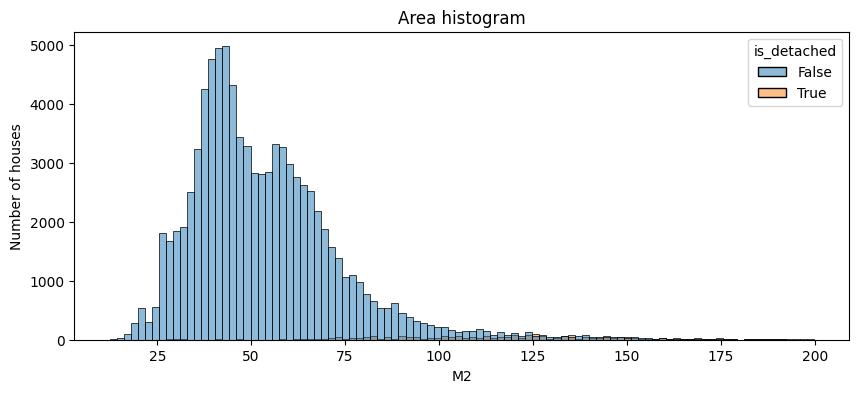

In [27]:
plt.figure(figsize=(10,4))
sns.histplot(data = data['all'][data['all']['area'] <=200],
             x='area',
             bins = 100,
             hue = 'is_detached')
plt.title("Area histogram")
plt.xlabel("M2")
plt.ylabel("Number of houses")
plt.show()

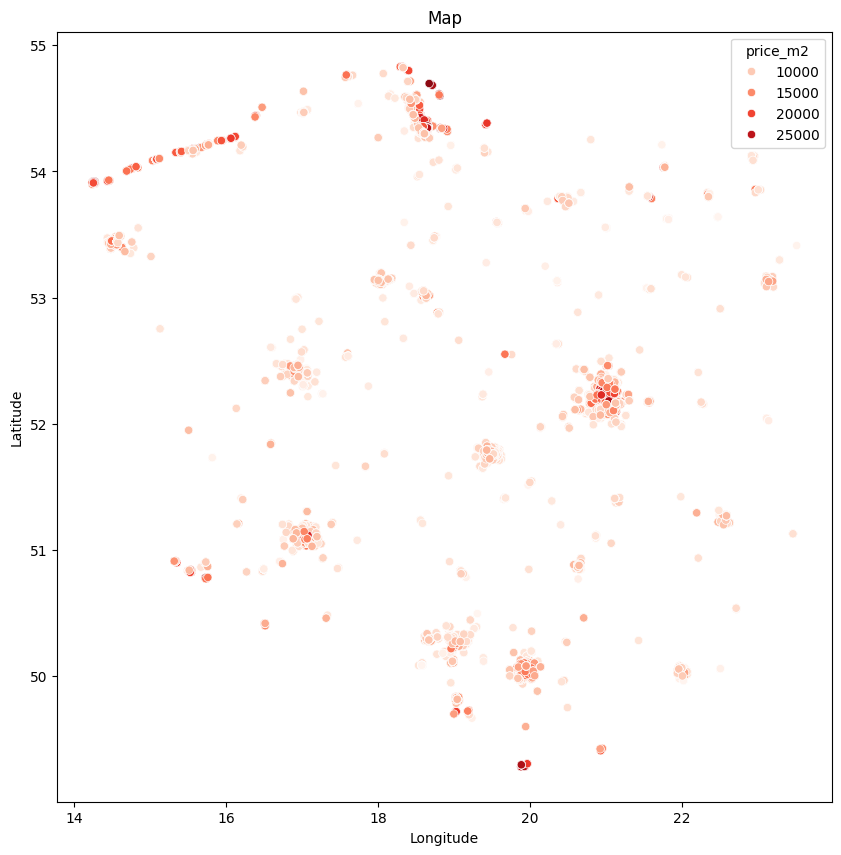

In [28]:
plt.figure(figsize=(10,10))
sns.scatterplot(data = data['all'],
             x='lng',
             y='lat',
             palette = "Reds",
             hue = 'price_m2')
plt.title("Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [29]:
data["all"].to_parquet("prices_v1.parquet", index = False)

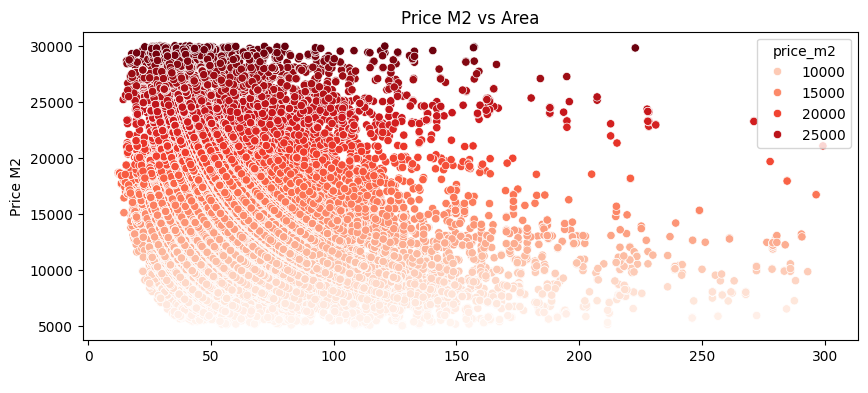

In [30]:
plt.figure(figsize=(10,4))
sns.scatterplot(data = data['all'][data['all']["area"] < 300],
             x='area',
             y='price_m2',
             palette = "Reds",
             hue = 'price_m2')
plt.title("Price M2 vs Area")
plt.xlabel("Area")
plt.ylabel("Price M2")
plt.show()

In [31]:
data["plot"] = data['all'][data['all']["area"] < 300][
                ["area",
                "price_m2"]]

In [32]:
data["plot"].loc[:, "area"] = data["plot"]["area"].round(0)

In [33]:
data["plot"] = data["plot"].groupby("area", as_index=False).aggregate(
                price_m2_mean = ("price_m2", "mean"),
                price_m2_count = ("price_m2", "count"))

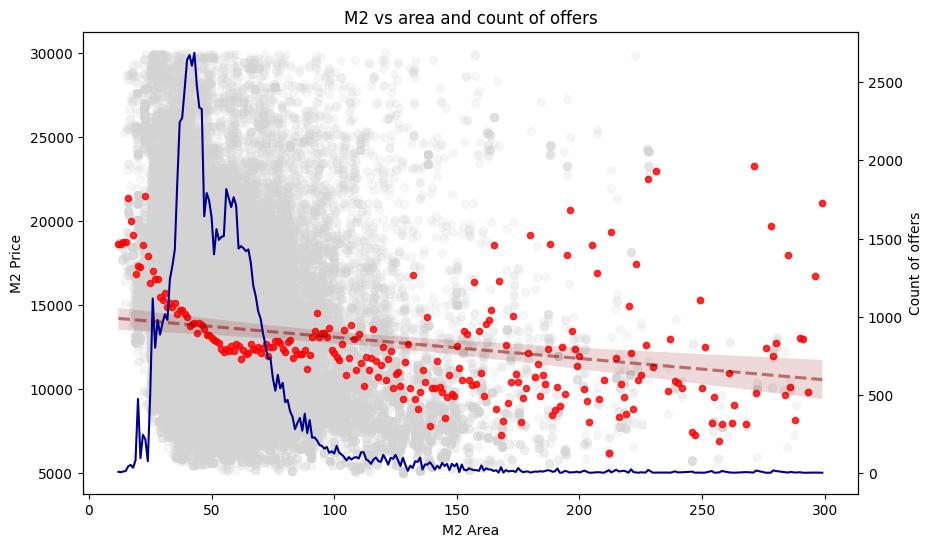

In [34]:
plt.figure(figsize=(10,6))
ax1 = plt.gca()
ax2 = ax1.twinx()
sns.scatterplot(data = data['all'][data['all']["area"] < 300],
             x='area',
             y='price_m2',
             alpha=0.2,
             edgecolor=None,
             facecolor="lightgray",
             ax=ax1,)

sns.regplot(data = data["plot"],
             x='area',
             y='price_m2_mean',
             color = "darkred",
             line_kws={"color": "darkred",
             "linestyle": "--",
             "alpha": 0.5},
             scatter_kws={"s": 20,
             "color": "red"},
             ax=ax1,)

ax1.set_ylabel("M2 Price")
ax1.set_xlabel("M2 Area")

sns.lineplot(data = data["plot"],
             x='area',
             y='price_m2_count',
             color = "darkblue",
             ax=ax2,)
ax2.set_ylabel("Count of offers")

plt.title("M2 vs area and count of offers")
plt.show()

In [35]:
data['all']['floor'] = data['all']['floor'].astype(int)

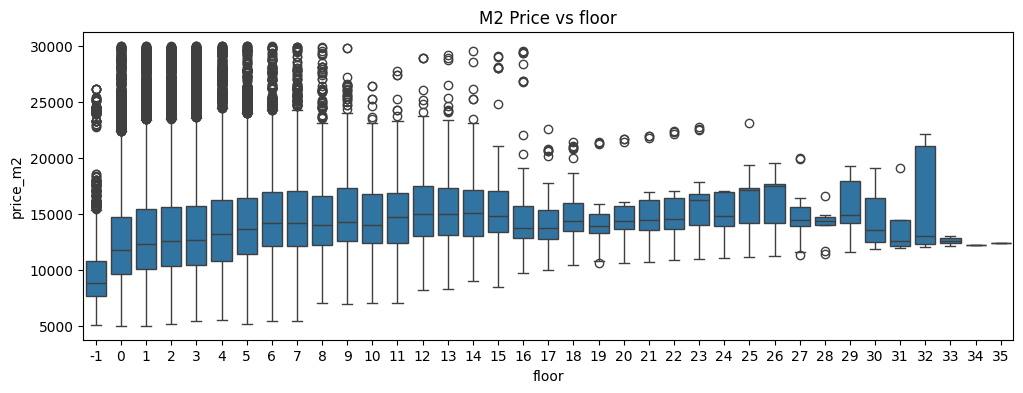

In [36]:
plt.figure(figsize=(12,4))
sns.boxplot(data = data['all'],
            x = "floor",
            y = "price_m2",)
plt.title("M2 Price vs floor")
plt.show()

In [37]:
data['all']['floor_max'] = data['all'].groupby(["city","developer","investment"])["floor"].transform("max")

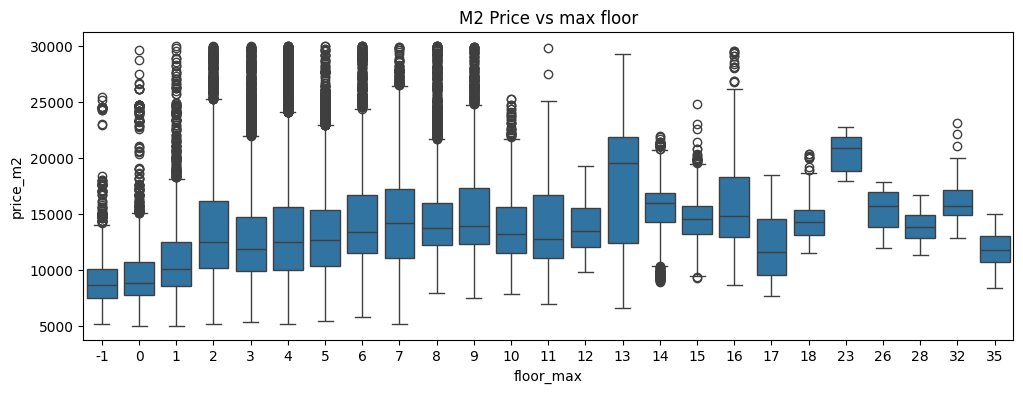

In [38]:
plt.figure(figsize=(12,4))
sns.boxplot(data = data['all'],
            x = "floor_max",
            y = "price_m2",)
plt.title("M2 Price vs max floor")
plt.show()

In [39]:
data['all']['top_floor'] = data['all']['floor'] == data['all']['floor_max']

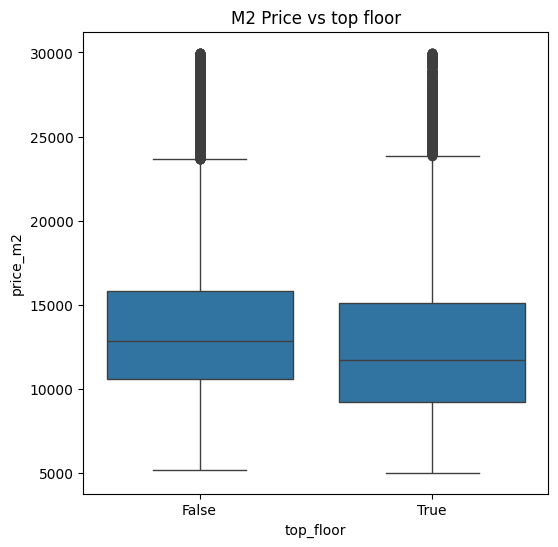

In [40]:
plt.figure(figsize=(6,6))
sns.boxplot(data = data['all'],
            x = "top_floor",
            y = "price_m2",)
plt.title("M2 Price vs top floor")
plt.show()

In [41]:
data['all']["has_balcony"] = data['all']["balcony"].apply(lambda x:1 if x>0 else 0)
data['all']["has_loggia"] = data['all']["loggia"].apply(lambda x:1 if x>0 else 0)
data['all']["has_terrace"] = data['all']["terrace"].apply(lambda x:1 if x>0 else 0)
data['all']["has_garden"] = data['all']["garden"].apply(lambda x:1 if x>0 else 0)
data['all']["balcony_and_loggia"] = data['all']["balcony"] + data['all']["loggia"]
data['all']["terrace_and_garden"] = data['all']["terrace"] + data['all']["garden"]

In [42]:
data['all'].groupby("has_balcony")["price_m2"].mean()

has_balcony
0    13319.311785
1    13520.679903
Name: price_m2, dtype: float64

In [43]:
for c in ["has_balcony", "has_loggia", "has_terrace", "has_garden"]: #avoid hard-coding
    print(data['all']\
    .groupby(c)["price_m2"]\
    .mean()\
    .to_markdown(),
    end="\n\n")

|   has_balcony |   price_m2 |
|--------------:|-----------:|
|             0 |    13319.3 |
|             1 |    13520.7 |

|   has_loggia |   price_m2 |
|-------------:|-----------:|
|            0 |    13375.2 |
|            1 |    13637.6 |

|   has_terrace |   price_m2 |
|--------------:|-----------:|
|             0 |    13423.3 |
|             1 |    12986   |

|   has_garden |   price_m2 |
|-------------:|-----------:|
|            0 |    13521.1 |
|            1 |    12235.8 |



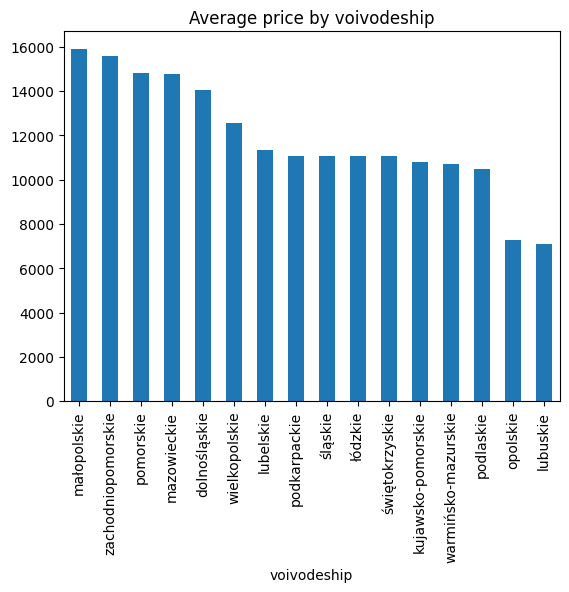

In [44]:
avg_price_by_voivodeship = data['all'].groupby("voivodeship")["price_m2"].mean().sort_values(ascending=False)
avg_price_by_voivodeship.plot(kind = "bar")
plt.title("Average price by voivodeship")
plt.show()


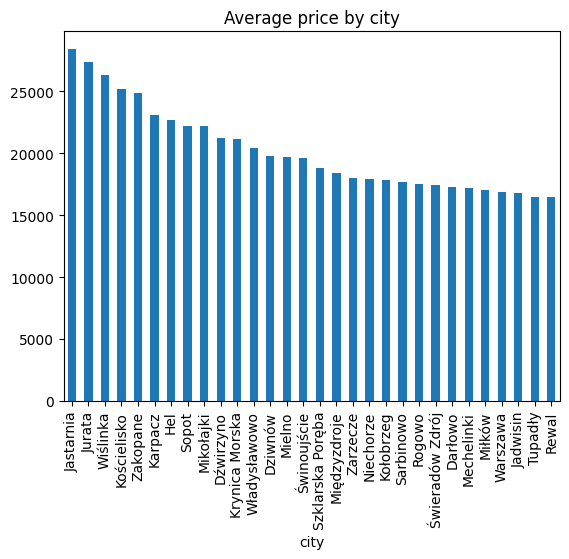

In [45]:
avg_price_by_city = data['all'].groupby("city")["price_m2"].mean().sort_values(ascending=False).head(30)
avg_price_by_city.plot(kind = "bar")
plt.title("Average price by city")
plt.show()

In [46]:
bins = [0, 30, 45, 60, 80, 100, 150, 200, 10_000]
labels = [
    "0-30m2",
    "30-45m2",
    "45-60m2",
    "60-80m2",
    "80-100m2",
    "100-150m2",
    "150-200m2",
    "200+m2",
]

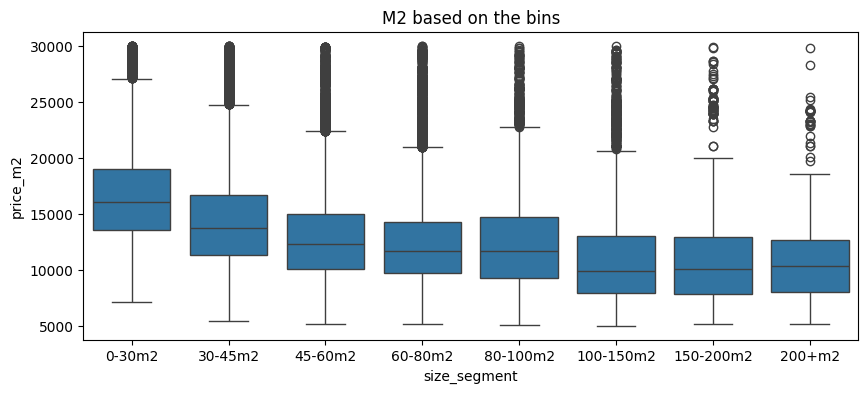

In [47]:
data['all']["size_segment"] = pd.cut(data['all']['area'],
            bins=bins,
            labels=labels)
plt.figure(figsize=(10, 4))
sns.boxplot(data=data['all'],
            x="size_segment",
            y="price_m2")
plt.title("M2 based on the bins")
plt.show()

## FOLIUM MAP

In [48]:
m = folium.Map(location = [data['all']['lat'].mean(), data['all']['lng'].mean()], zoom_start=7)
heat_data = [[row["lat"], row["lng"], row["price_m2"]] for _, row in data['all'].iterrows()]
HeatMap(heat_data).add_to(m)
m

## PRICE PER GMINA

In [49]:
data["gminy_map"] = gpd.read_file("A03_Granice_gmin.shp", encoding = "Latin-2")
data["gminy_map"] = data["gminy_map"].to_crs(epsg = 2180)
data["gminy_map"]["centroid"] = data["gminy_map"].geometry.centroid
data["gminy_map"]["centroid"] = data["gminy_map"]["centroid"].to_crs(epsg=4326)
data["warsaw_centroid"] = data["gminy_map"][data["gminy_map"]["JPT_KOD_JE"] == "1465011"]["centroid"].values[0]
data["special_map"] = gpd.read_file("A05_Granice_jednostek_ewidencyjnych.shp",
                                encoding = "Latin-2")
data["warsaw_map"] = data["special_map"][data["special_map"]["JPT_KOD_JE"].str.startswith("1465")][["JPT_KOD_JE","JPT_NAZWA_", "geometry"]]
data["warsaw_map"] = data["warsaw_map"].to_crs(epsg=2180)
data["warsaw_map"]["centroid"] = data["warsaw_centroid"]
data["map_gminy"] = pd.concat([data["gminy_map"][data["gminy_map"]["JPT_KOD_JE"]!= "1465011"][
                               ["JPT_KOD_JE", "JPT_NAZWA_", "geometry", "centroid"]],
                               data["warsaw_map"]],axis=0,)
data["map_gminy"]["gmina_area"] = data["map_gminy"]["geometry"].area
data["map_gminy"]["gmina_area"] = data["map_gminy"]["gmina_area"]/1_000_000
data["map_gminy"] = data["map_gminy"].to_crs(epsg = 4326)

In [50]:
data["map_gminy"]["woj_teryt"] = data["map_gminy"]["JPT_KOD_JE"].apply(lambda s:s[:2])

In [51]:
# dict for matching voivodeship with TERYT code
woj_teryt_map = {
    "dolnośląskie": "02",
    "kujawsko-pomorskie": "04",
    "lubelskie": "06",
    "lubuskie": "08",
    "łódzkie": "10",
    "małopolskie": "12",
    "mazowieckie": "14",
    "opolskie": "16",
    "podkarpackie": "18",
    "podlaskie": "20",
    "pomorskie": "22",
    "śląskie": "24",
    "świętokrzyskie": "26",
    "warmińsko-mazurskie": "28",
    "wielkopolskie": "30",
    "zachodniopomorskie": "32",
}

## GETTING "TERYT" FROM COORDINATES

In [52]:
def get_teryt_from_coordinates(map_df, lat, lng, woj):
    point = Point(lng, lat)

    woj_map = map_df[map_df["woj_teryt"] == woj_teryt_map[woj]]

    for idx, row in woj_map.iterrows():
        if row["geometry"].contains(point):
            return row["JPT_KOD_JE"]

    return None

In [53]:
data["all"]["teryt"] = [get_teryt_from_coordinates(data["map_gminy"], lat, lng, woj) 
                        for lat, lng, woj in tqdm(zip(data["all"]["lat"], data["all"]["lng"], data["all"]["voivodeship"]
                                                ), total = len(data["all"]))]

100%|████████████████████████████████████| 91471/91471 [05:11<00:00, 293.46it/s]
